In [1]:
pip install pytorchvideo

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torchvision.io as io
import os
from torch.utils.data import Dataset, DataLoader
#from pytorchvideo.models.hub import slowfast_r50


In [19]:
base_dir = "/projects/dsci410/baseballprediction/pitch_classifier"


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pschale/mlb-pitch-data-20152018")

print("Path to dataset files:", path)

Path to dataset files: /home/nikhils/.cache/kagglehub/datasets/pschale/mlb-pitch-data-20152018/versions/2


In [4]:
pitches = pd.read_csv('pitchdata/pitches.csv')
atbats = pd.read_csv('pitchdata/atbats.csv')
names = pd.read_csv('pitchdata/player_names.csv')

In [5]:
filtered_atbats = atbats[(atbats['batter_id'] == 453286) | (atbats['pitcher_id'] == 453286)]

In [6]:
filtered_atbats.head()

,ab_id,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top
631,2015000632,434158,Walk,201500010,1,0,0,R,453286,L,True
632,2015000633,431151,Pop Out,201500010,1,1,0,R,453286,R,True
633,2015000634,446263,Strikeout,201500010,1,2,0,R,453286,L,True
634,2015000635,150212,Groundout,201500010,1,3,0,R,453286,R,True
640,2015000641,502517,Flyout,201500010,2,1,0,R,453286,L,True


In [7]:
filtered_atbats1 = filtered_atbats[['pitcher_id', 'ab_id', 'g_id']]
filtered_pitches = pitches[['ab_id', 'spin_rate', 'type_confidence', 'pitch_type', 'pitch_num']]

validating = pd.merge(filtered_atbats1, filtered_pitches, on='ab_id', how='inner')
validating.head()

,pitcher_id,ab_id,g_id,spin_rate,type_confidence,pitch_type,pitch_num
0,453286,2015000632,201500010,2704.451,2.0,FF,1.0
1,453286,2015000632,201500010,2536.460,2.0,FF,2.0
2,453286,2015000632,201500010,2546.016,2.0,FF,3.0
3,453286,2015000632,201500010,1628.200,2.0,CH,4.0
4,453286,2015000632,201500010,2040.141,2.0,FF,5.0


In [8]:
games = pd.read_csv('pitchdata/games.csv')
filtered_games = games[['g_id', 'date']]
most_valid = pd.merge(validating, filtered_games, on='g_id', how='inner')
start_date = '2018-01-01'
end_date = '2018-12-31'
most_valid = most_valid.loc[(most_valid['date'] >= start_date) & (most_valid['date'] <= end_date)]
most_valid

,pitcher_id,ab_id,g_id,spin_rate,type_confidence,pitch_type,pitch_num,date
10811,453286,2018001877,201800024,2134.325,2.000,FF,1.0,2018-03-30
10812,453286,2018001877,201800024,2356.836,2.000,FF,2.0,2018-03-30
10813,453286,2018001877,201800024,734.463,2.000,FC,3.0,2018-03-30
10814,453286,2018001877,201800024,2371.196,2.000,FF,4.0,2018-03-30
10815,453286,2018001877,201800024,2037.082,2.000,CH,5.0,2018-03-30
...,...,...,...,...,...,...,...,...
14579,453286,2018179463,201802352,2045.125,0.906,FF,8.0,2018-09-25
14580,453286,2018179463,201802352,1638.230,0.877,FF,9.0,2018-09-25
14581,453286,2018179463,201802352,183.841,0.892,SL,10.0,2018-09-25
14582,453286,2018179464,201802352,2144.930,0.898,FF,1.0,2018-09-25


In [29]:
from torch.utils.data import Dataset
import torchvision.io as io
from torchvision import transforms

class CustomVideoDataset(Dataset):
    def __init__(self, video_dir, transform=None, pitch_mapping=None):
        """
        Args:
            video_dir (string): Directory containing the video files.
            transform (callable, optional): Optional transform to be applied on the video tensor.
        """
        self.video_dir = video_dir
        self.video_files = [
            os.path.join(video_dir, f) for f in os.listdir(video_dir)
            if f.lower().endswith('.avi')
        ]
        print(f"Found {len(self.video_files)} video files in {video_dir}")
        self.transform = transform

        if pitch_mapping is None:
            self.pitch_mapping = {
                "CH": 0,
                "FF": 1,
                "SL": 2,
                "CU": 3,
                "FC": 4
            }
        else:
            self.pitch_mapping = pitch_mapping

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        video_path = self.video_files[idx]
        video_tensor, audio_tensor, metadata = io.read_video(video_path, pts_unit='sec')
        
        # Extract pitch type from filename.
        # Example filename: "3_30_2018_4_slider.avi"
        base = os.path.basename(video_path)
        name_without_ext = os.path.splitext(base)[0]
        parts = name_without_ext.split('_')
        # Assume the last part is the pitch type:
        pitch_str = parts[-1]
        label = self.pitch_mapping.get(pitch_str, -1)
        if label == -1:
            print(f"Warning: Unknown pitch type '{pitch_str}' in file {base}.")
        
        if self.transform:
            video_tensor = self.transform(video_tensor)
        
        return video_tensor, label


In [30]:
import torch.nn.functional as F

def temporal_subsample(video, num_frames=32):
    T = video.shape[0]
    if T >= num_frames:
        indices = torch.linspace(0, T - 1, steps=num_frames).long()
        return torch.index_select(video, 0, indices)
    else:
        return video

        
def resize_video_tensor(video, size=(112,112)):
    """
    Resize a video tensor.
    Args:
      video: Tensor of shape (T, H, W, C)
      size: Tuple (new_height, new_width)
    Returns:
      Resized video tensor of shape (T, H_new, W_new, C)
    """
    # Permute to (T, C, H, W)
    video = video.permute(0, 3, 1, 2)
    # Resize all frames at once
    video = F.interpolate(video, size=size, mode='bilinear', align_corners=False)
    # Permute back to (T, H, W, C)
    video = video.permute(0, 2, 3, 1)
    return video




In [31]:
from torch.utils.data import random_split
from torchvision.transforms import Resize, Compose
from torchvision import transforms

video_transform = transforms.Compose([
    lambda x: x.float() / 255.0,
    lambda x: temporal_subsample(x, num_frames=32),
    lambda x: resize_video_tensor(x, size=(112, 112))
])

#collate function to pad videos in a batch to have the same number of frames by adding zeros so every video length matches the max 
def custom_collate_fn(batch):
    """
    Batch is a list of tuples: (video_tensor, label).
    Each video_tensor has shape: (num_frames, H, W, C) where num_frames may vary.
    This function pads videos so that all have the same number of frames and then
    permutes the dimensions to (batch, C, num_frames, H, W).
    """
    videos, labels = zip(*batch)
    
    # Find maximum number of frames in the batch
    max_frames = max(video.shape[0] for video in videos)
    
    padded_videos = []
    for video in videos:
        num_frames, H, W, C = video.shape
        pad_frames = max_frames - num_frames
        if pad_frames > 0:
            # Create padding with zeros
            padding = torch.zeros((pad_frames, H, W, C), dtype=video.dtype)
            # Concatenate the padding to the video
            video = torch.cat([video, padding], dim=0)
        padded_videos.append(video)
    
    # Stack padded videos: shape (batch, max_frames, H, W, C)
    padded_videos = torch.stack(padded_videos)
    
    # Permute dimensions to (batch, C, max_frames, H, W)
    padded_videos = padded_videos.permute(0, 4, 1, 2, 3)
    
    # Convert labels to a tensor
    labels = torch.tensor(labels)
    
    return padded_videos, labels


In [32]:
video_dir = 'avi_files_for_loader/'

dataset = CustomVideoDataset(video_dir=video_dir, transform=video_transform)

total_samples = len(dataset)
train_size = int(0.8 * total_samples)
val_size = int(0.1 * total_samples)
test_size = total_samples - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


Found 852 video files in avi_files_for_loader/


In [33]:
from torch.utils.data import DataLoader

batch_size = 3
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

for batch_videos, batch_labels in train_loader:
    print(f"Batch videos shape: {batch_videos.shape}") 
    break

Batch videos shape: torch.Size([3, 3, 32, 112, 112])


In [34]:
import torch.optim as optim
import torchvision.models.video as video_models
import torch.nn as nn
from torchvision.models.video import r3d_18, R3D_18_Weights

device = 'cuda' if torch.cuda.is_available() else 'cpu'
weights = R3D_18_Weights.DEFAULT
model = video_models.r3d_18(weights=weights).to(device)

print(device)

cuda


In [35]:
for param in model.parameters():
    param.requires_grad = False

num_classes = 5
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes).to(device)

for param in model.fc.parameters():
    param.requires_grad = True


In [36]:
import torch
import torch.optim as optim
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

train_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    for videos, labels in tqdm(train_loader):
        videos = videos.to(device)  # Shape: (batch, C, T, H, W)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(videos)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = total_correct / total_samples
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
    
    # Validation step
    model.eval()
    val_correct = 0
    val_samples = 0
    with torch.no_grad():
        for videos, labels in val_loader:
            videos = videos.to(device)
            labels = labels.to(device)
            outputs = model(videos)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_samples += labels.size(0)
    
    val_accuracy = val_correct / val_samples
    val_accuracies.append(val_accuracy)
    print(f"Validation Accuracy: {val_accuracy:.4f}")


100%|██████████| 227/227 [05:35<00:00,  1.48s/it]


Epoch 1/3 - Loss: 1.4720, Accuracy: 0.4640
Validation Accuracy: 0.4706


100%|██████████| 227/227 [05:33<00:00,  1.47s/it]


Epoch 2/3 - Loss: 1.4347, Accuracy: 0.4978
Validation Accuracy: 0.4471


100%|██████████| 227/227 [05:29<00:00,  1.45s/it]


Epoch 3/3 - Loss: 1.4491, Accuracy: 0.4699
Validation Accuracy: 0.4706


In [37]:
# After training is complete...
model.eval()
test_correct = 0
test_samples = 0
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for videos, labels in test_loader:
        videos = videos.to(device)
        labels = labels.to(device)
        outputs = model(videos)
        preds = outputs.argmax(dim=1)
        
        test_correct += (preds == labels).sum().item()
        test_samples += labels.size(0)
        
        # Collect for detailed metrics
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

test_accuracy = test_correct / test_samples
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.5233


In [38]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report

import numpy as np

all_test_preds = np.array(all_test_preds)
all_test_labels = np.array(all_test_labels)

precision = precision_score(all_test_labels, all_test_preds, average='macro')
recall    = recall_score(all_test_labels, all_test_preds, average='macro')
f1        = f1_score(all_test_labels, all_test_preds, average='macro')

print(f"Test Precision: {precision:.4f}")
print(f"Test Recall:    {recall:.4f}")
print(f"Test F1 Score:  {f1:.4f}")

# Detailed classification report
print(classification_report(all_test_labels, all_test_preds, target_names=["CH", "FF", "SL", "CU", "FC"]))

# Confusion matrix
cm = confusion_matrix(all_test_labels, all_test_preds)
print("Confusion Matrix:\n", cm)

Test Precision: 0.1047
Test Recall:    0.2000
Test F1 Score:  0.1374
              precision    recall  f1-score   support

          CH       0.00      0.00      0.00        14
          FF       0.52      1.00      0.69        45
          SL       0.00      0.00      0.00        12
          CU       0.00      0.00      0.00         2
          FC       0.00      0.00      0.00        13

    accuracy                           0.52        86
   macro avg       0.10      0.20      0.14        86
weighted avg       0.27      0.52      0.36        86

Confusion Matrix:
 [[ 0 14  0  0  0]
 [ 0 45  0  0  0]
 [ 0 12  0  0  0]
 [ 0  2  0  0  0]
 [ 0 13  0  0  0]]


/home/nikhils/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nikhils/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nikhils/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nikhils/.local/lib/python3.8/site-packages/s

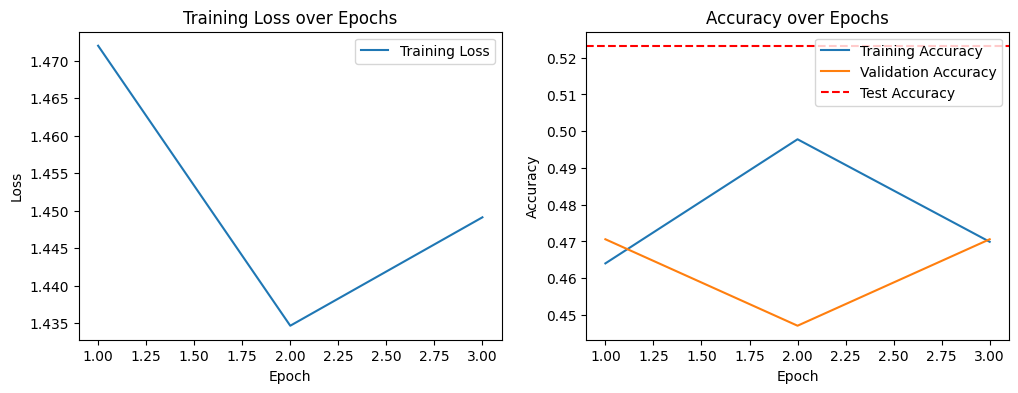

In [39]:
import matplotlib.pyplot as plt

epochs_range = range(1, num_epochs+1)
plt.figure(figsize=(12, 4))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()


/home/nikhils/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nikhils/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nikhils/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


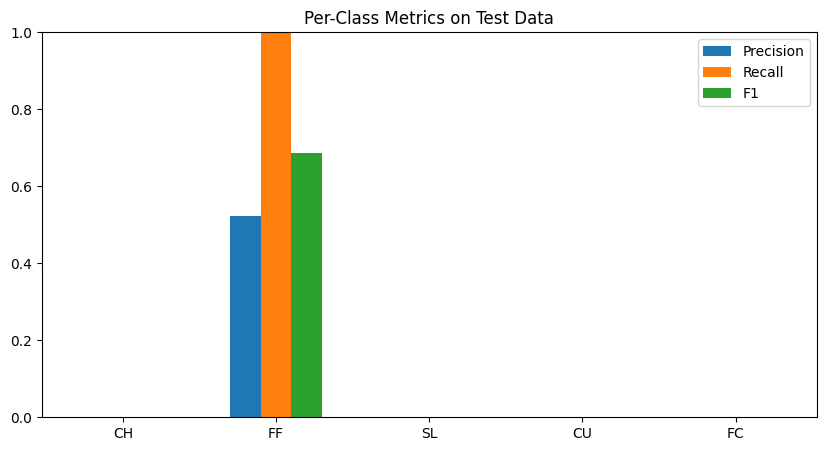

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

classes = ["CH", "FF", "SL", "CU", "FC"]
report = classification_report(all_test_labels, all_test_preds, target_names=classes, output_dict=True)

precisions = [report[cls]["precision"] for cls in classes]
recalls    = [report[cls]["recall"] for cls in classes]
f1s        = [report[cls]["f1-score"] for cls in classes]

x = np.arange(len(classes))
width = 0.2

plt.figure(figsize=(10,5))
plt.bar(x - width, precisions, width=width, label='Precision')
plt.bar(x, recalls, width=width, label='Recall')
plt.bar(x + width, f1s, width=width, label='F1')
plt.xticks(x, classes)
plt.ylim(0, 1)
plt.title('Per-Class Metrics on Test Data')
plt.legend()
plt.show()



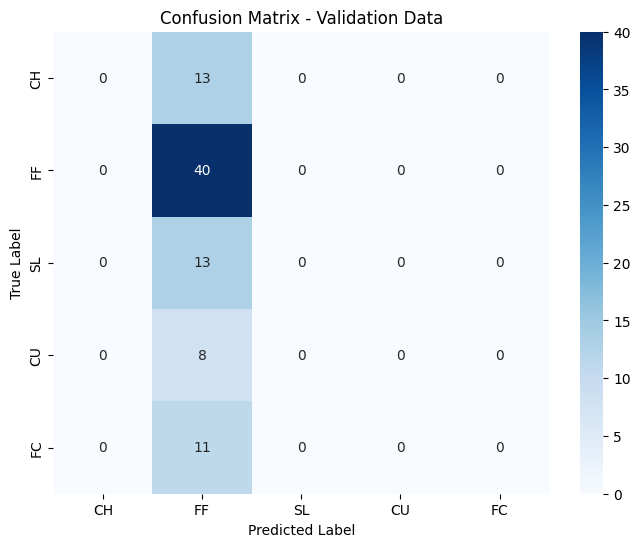

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Collect predictions and true labels
val_preds = []
val_labels = []

model.eval()
with torch.no_grad():
    for videos, labels in val_loader:
        videos = videos.to(device)
        labels = labels.to(device)
        outputs = model(videos)
        preds = outputs.argmax(dim=1)
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Define your class labels
classes = ["CH", "FF", "SL", "CU", "FC"]

# Visualize using seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Validation Data')
plt.show()


In [42]:
torch.save(model.state_dict(), 'model_weights.pth')